# PRM Algorithm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle
import numpy as np
from matplotlib import collections  as mc
import random
import pandas as pd

import tensorflow as tf
import keras as keras
from keras.layers import PReLU
from keras import layers, losses, models
from keras.models import Model

from sklearn.neural_network import MLPRegressor

import time
import pickle
from utilityPRM import *

In [2]:
print(tf.__version__)

2.12.0


# Laberinto

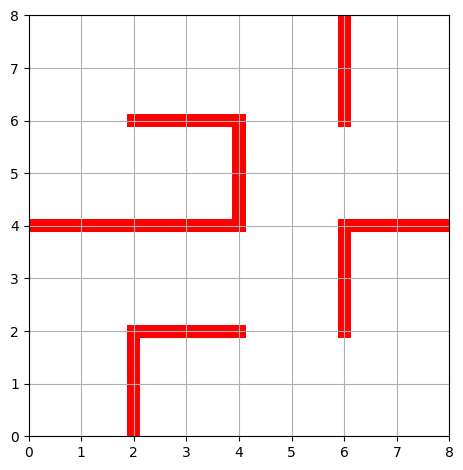

In [3]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

plt.grid()
plt.tight_layout()
plt.show()

# Algoritmo PRM

In [ ]:
#La opcion 'pointsInTxt' sirve para usar posiciones de los nodos del grafo contenidas en un txt y limitar con ello la aleatoriedad
Vertices, Edges, Neighbors = PRM(5000, rootVertex, v_r, d_t, pointsInTxt=True)

Leyendo archivo de texto existente...
0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


### Visualización del grafo

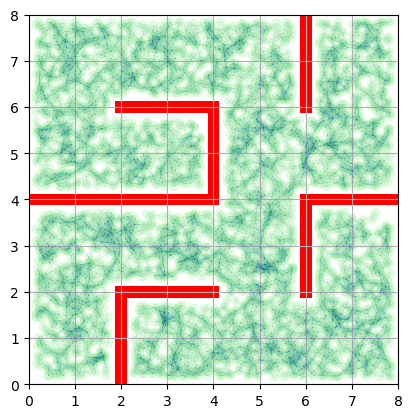

In [ ]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(Edges, linewidths=0.01)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in Vertices:
  if v == rootVertex:
    #plt.scatter(v.x, v.y, color = 'blue')
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='black', alpha = 0.25))
  else:
    #plt.scatter(v.x, v.y, color = 'black', s=1.5)
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='lightgreen', alpha = 0.25))

plt.grid()
plt.show()

### Guardar listas obtenidas

In [ ]:
# Guardar las listas en un archivo

with open("vertices.pkl", "wb") as f:
    pickle.dump(Vertices, f)

with open("edges.pkl", "wb") as f:
    pickle.dump(Edges, f)

with open("neighbors.pkl", "wb") as f:
    pickle.dump(Neighbors, f)

### Cargar listas obtenidas

In [4]:
# Cargar las listas desde el archivo

with open("vertices.pkl", "rb") as f:
    Vertices = pickle.load(f)

with open("edges.pkl", "rb") as f:
    Edges = pickle.load(f)

with open("neighbors.pkl", "rb") as f:
    Neighbors = pickle.load(f)

## Algoritmo de Dijkstra y obtención de trayectorias

### Obtención de camino (sin obstáculo dinámico)

In [5]:
init_x = 7
init_y = 7

goal_x = 3
goal_y = 5
goal_r = 0.75

pathToGoalV, pathToGoalE = getPath(Vertices, Neighbors, [init_x, init_y], [goal_x, goal_y], goal_r)

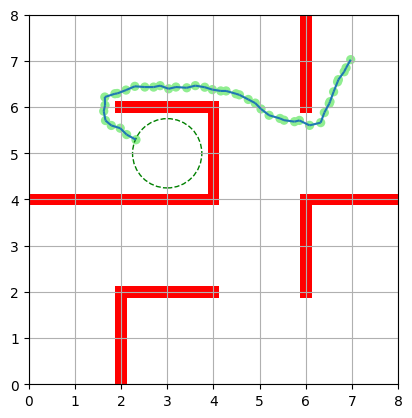

In [6]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(pathToGoalE, linewidths=1.5)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in pathToGoalV:
  if v == rootVertex:
    #plt.scatter(v.x, v.y, color = 'blue')
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='blue', alpha = 1.0))
  else:
    #plt.scatter(v.x, v.y, color = 'black', s=1.5)
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='lightgreen', alpha = 1.0))

ax.add_patch(Circle((goal_x, goal_y), goal_r, edgecolor='green', ls = '--', fill = False))

plt.grid()
plt.show()

### Obtención de camino (con obstáculo dinámico)

In [7]:
init_x = 7
init_y = 7

goal_x = 3
goal_y = 5
goal_r = 0.75

obst_x = 7
obst_y = 6

pathToGoalV, pathToGoalE = getPathObst(Vertices, Neighbors, [init_x, init_y], [obst_x, obst_y], obst_reach, [goal_x, goal_y], goal_r)

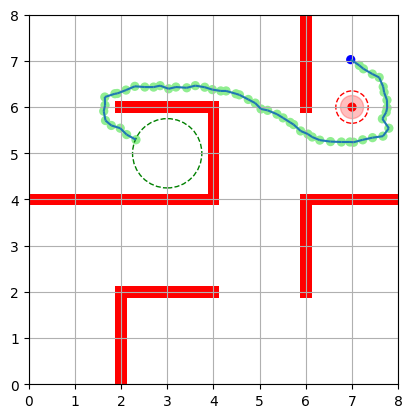

In [8]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

lc = mc.LineCollection(pathToGoalE, linewidths=1.5)
ax.add_collection(lc)

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in pathToGoalV:
  if v == pathToGoalV[0]:
    #plt.scatter(v.x, v.y, color = 'blue')
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='blue', alpha = 1.0))
  else:
    #plt.scatter(v.x, v.y, color = 'black', s=1.5)
    ax.add_patch(Circle((v.x, v.y), robot_r, facecolor='lightgreen', alpha = 1.0))

ax.add_patch(Circle((goal_x, goal_y), goal_r, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obst_x, obst_y), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obst_x, obst_y), v_obst*d_t, edgecolor='red', facecolor='red', ls = '-', alpha = 0.25))
ax.add_patch(Circle((obst_x, obst_y), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

# Recopilación de trayectorias para entrenamiento

### Parámetros para las trayectorias a considerar

In [34]:
samplesPerCell = 10 #En el modelo completo, en teoria consideramos 10 posiciones INICIALES del robot para cada celda

## Posiciones iniciales del robot y del obstáculo dinámico

### Posiciones iniciales

In [ ]:
initSamples = []

for c in mazeCells:
    i = 0
    while i < samplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius):
            initSamples.append(np.array([xrand_x, xrand_y]))
            i+=1

### Posiciones de obstáculo dinámico

15 posiciones por celda

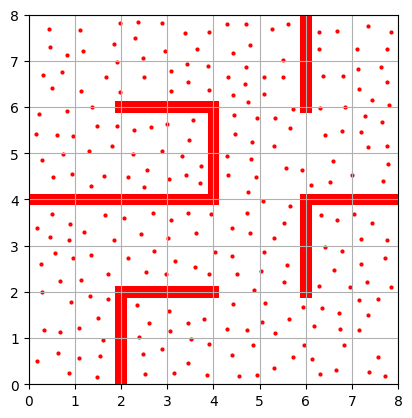

In [11]:
obstSamplesPerCell = 15
obstSamples = []
minDist = 0.35

for c in mazeCells:
    i = 0
    while i < obstSamplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius) and checkMinDist([xrand_x, xrand_y], obstSamples, minDist):
            obstSamples.append(np.array([xrand_x, xrand_y]))
            i+=1

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for o in obstSamples:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

20 posiciones por celda

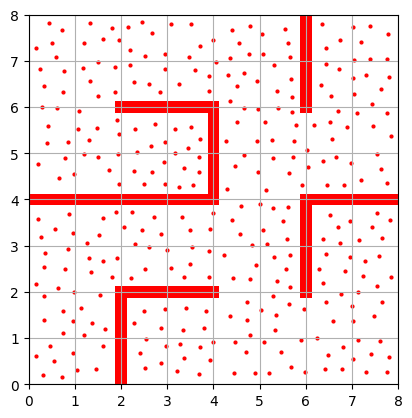

In [14]:
obstSamplesPerCell = 20
obstSamples20 = []
minDist = 0.3

for c in mazeCells:
    i = 0
    while i < obstSamplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius) and checkMinDist([xrand_x, xrand_y], obstSamples20, minDist):
            obstSamples20.append(np.array([xrand_x, xrand_y]))
            i+=1

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for o in obstSamples20:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

25 posiciones por celda

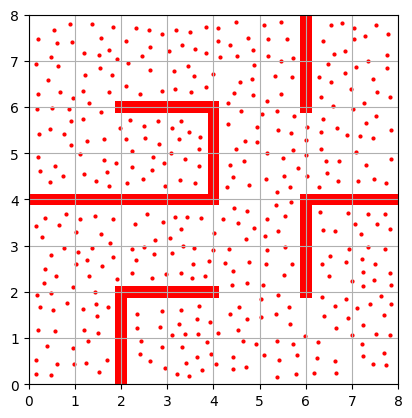

In [19]:
obstSamplesPerCell = 25
obstSamples25 = []
minDist = 0.25

for c in mazeCells:
    i = 0
    while i < obstSamplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius) and checkMinDist([xrand_x, xrand_y], obstSamples25, minDist):
            obstSamples25.append(np.array([xrand_x, xrand_y]))
            i+=1

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for o in obstSamples25:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

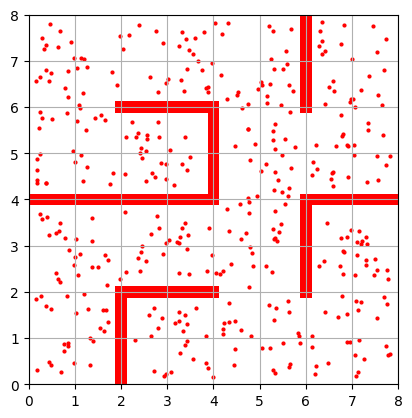

In [11]:
obstSamplesPerCell = 25
obstSamples25alt = []
minDist = 0.25

for c in mazeCells:
    i = 0
    while i < obstSamplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius):
            obstSamples25alt.append(np.array([xrand_x, xrand_y]))
            i+=1

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for o in obstSamples25alt:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

30 posiciones por celda

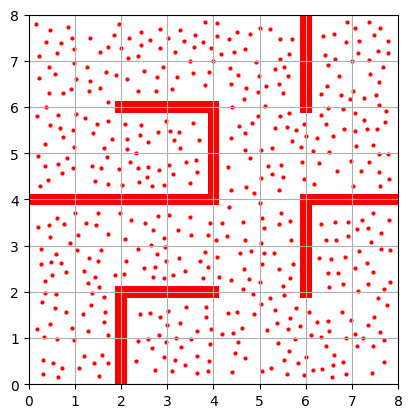

In [39]:
obstSamplesPerCell = 30
obstSamples30 = []
minDist = 0.2

for c in mazeCells:
    i = 0
    while i < obstSamplesPerCell:
        #Generamos punto aleatorio xrand
        xrand_x = np.random.uniform(c.infX, c.supX)
        xrand_y = np.random.uniform(c.infY, c.supY)

        #Verificamos que el punto aleatorio este libre de colisiones
        if sampleFree(xrand_x, xrand_y, connect_radius) and checkMinDist([xrand_x, xrand_y], obstSamples30, minDist):
            obstSamples30.append(np.array([xrand_x, xrand_y]))
            i+=1

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for o in obstSamples30:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

Guardamos las muestras de los puntos iniciales en archivo de texto

**IMPORTANTE: Ejecutar solo una vez los siguientes dos modulos, para evitar que los archivos de texto se sobreescriban y se pierdan**

In [ ]:
file = open("initialPoints.txt", "w")

for s in initSamples:
    file.write(str(s[0]))
    file.write(" ")
    file.write(str(s[1]))
    file.write("\n")

file.close()

In [20]:
file = open("obstaclePoints.txt", "w")

for o in obstSamples:
    file.write(str(o[0]))
    file.write(" ")
    file.write(str(o[1]))
    file.write("\n")

file.close()

In [21]:
file = open("obstaclePoints20.txt", "w")

for o in obstSamples20:
    file.write(str(o[0]))
    file.write(" ")
    file.write(str(o[1]))
    file.write("\n")

file.close()

In [22]:
file = open("obstaclePoints25.txt", "w")

for o in obstSamples25:
    file.write(str(o[0]))
    file.write(" ")
    file.write(str(o[1]))
    file.write("\n")

file.close()

In [40]:
file = open("obstaclePoints30.txt", "w")

for o in obstSamples30:
    file.write(str(o[0]))
    file.write(" ")
    file.write(str(o[1]))
    file.write("\n")

file.close()

### Lectura de muestras iniciales y de obstáculo por archivos de texto existentes

In [35]:
initialPoints = []

with open("initialPoints.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        initialPoints.append(np.array([x, y]))

Modelo con 15 muestras de obstaculo dinamico por celda

In [23]:
obstaclePoints = []

with open("obstaclePoints.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        obstaclePoints.append(np.array([x, y]))

Modelo con 20 muestras de obstaculo dinamico por celda

In [24]:
obstaclePoints20 = []

with open("obstaclePoints20.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        obstaclePoints20.append(np.array([x, y]))

Modelo con 25 muestras de obstaculo dinamico por celda

In [25]:
obstaclePoints25 = []

with open("obstaclePoints25.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        obstaclePoints25.append(np.array([x, y]))

Modelo con 30 muestras de obstáculo dinámico por celda

In [26]:
obstaclePoints30 = []

with open("obstaclePoints30.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        obstaclePoints30.append(np.array([x, y]))

### Clasificación de las muestras por celda (con el fin de poder iterar sobre cada celda)

In [36]:
initialPointsCell = []

for i in range(16):
    pointsOfCell = []
    for j in range(samplesPerCell):
        pointsOfCell.append(initialPoints[samplesPerCell*i + j])

    initialPointsCell.append(pointsOfCell)
    i+=1

In [28]:
obstPointsCell = []

for i in range(16):
    obstOfCell = []
    for j in range(15):
        obstOfCell.append(obstaclePoints[15*i + j])

    obstPointsCell.append(obstOfCell)
    i+=1

In [29]:
obstPointsCell20 = []

for i in range(16):
    obstOfCell = []
    for j in range(20):
        obstOfCell.append(obstaclePoints20[20*i + j])

    obstPointsCell20.append(obstOfCell)
    i+=1

In [30]:
obstPointsCell25 = []

for i in range(16):
    obstOfCell = []
    for j in range(25):
        obstOfCell.append(obstaclePoints25[25*i + j])

    obstPointsCell25.append(obstOfCell)
    i+=1

In [31]:
obstPointsCell30 = []

for i in range(16):
    obstOfCell = []
    for j in range(30):
        obstOfCell.append(obstaclePoints30[30*i + j])

    obstPointsCell30.append(obstOfCell)
    i+=1

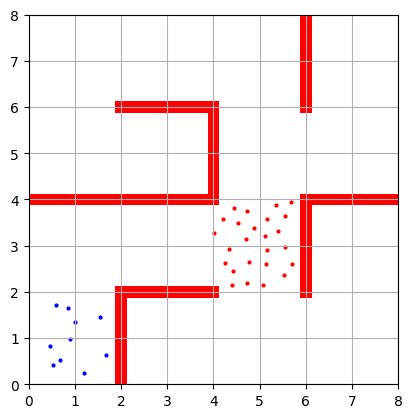

In [40]:
fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))


for p in initialPointsCell[0]:
    plt.scatter(p[0], p[1], color = 'blue', s=4.0)

for p in obstPointsCell25[6]:
    plt.scatter(p[0], p[1], color = 'red', s=4.0)

plt.grid()
plt.show()

## Prueba con 15 obstaculos dinamicos por celda y objetivo fijo

In [41]:
obstSamplesPerCell = 15
trayectorias = []
initCell = 0
goalCell = 9
init = [1.0, 1.0]
failed = 0

file = open("trayectorias_15_obst.txt", "w")

goalx = (mazeCells[goalCell].supX - mazeCells[goalCell].infX)/2 + mazeCells[goalCell].infX
goaly = (mazeCells[goalCell].supY - mazeCells[goalCell].infY)/2 + mazeCells[goalCell].infY
goalr = 0.75


for obstCell in range(16):

    if obstCell != initCell:
        print("Celda de obstaculo dinamico:", obstCell)
        print("   Muestras procesadas:")

        for obst_id in range(obstSamplesPerCell):
            print("  ", obst_id, end="")
            obstx = obstPointsCell[obstCell][obst_id][0]
            obsty = obstPointsCell[obstCell][obst_id][1]

            pathV, pathE = getPathObst(Vertices, Neighbors, [init[0], init[1]], [obstx, obsty], obst_reach, [goalx, goaly], goalr)

            if pathV != None:
                for v in pathV:
                    file.write(str(v.x))
                    file.write(" ")
                    file.write(str(v.y))
                    file.write(" ")

                file.write(str(goalx))
                file.write(" ")
                file.write(str(goaly))
                file.write(" ")
                file.write(str(obstx))
                file.write(" ")
                file.write(str(obsty))
                file.write("\n")
            else:
                failed += 1

        print()

print("Trayectorias fallidas:", failed)
file.close()

Celda de obstaculo dinamico: 1
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 2
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 3
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 4
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 5
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 6
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 7
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 8
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14
Celda de obstaculo dinamico: 9
 

## Prueba con 20 obstaculos dinamicos por celda y objetivo fijo

In [42]:
obstSamplesPerCell = 20

trayectorias = []
initCell = 0
goalCell = 9
init = [1.0, 1.0]
failed = 0

file = open("trayectorias_20_obst.txt", "w")

goalx = (mazeCells[goalCell].supX - mazeCells[goalCell].infX)/2 + mazeCells[goalCell].infX
goaly = (mazeCells[goalCell].supY - mazeCells[goalCell].infY)/2 + mazeCells[goalCell].infY
goalr = 0.75


for obstCell in range(16):

    if obstCell != initCell:
        print("Celda de obstaculo dinamico:", obstCell)
        print("   Muestras procesadas:")

        for obst_id in range(obstSamplesPerCell):
            print("  ", obst_id, end="")
            obstx = obstPointsCell20[obstCell][obst_id][0]
            obsty = obstPointsCell20[obstCell][obst_id][1]

            pathV, pathE = getPathObst(Vertices, Neighbors, [init[0], init[1]], [obstx, obsty], obst_reach, [goalx, goaly], goalr)

            if pathV != None:
                for v in pathV:
                    file.write(str(v.x))
                    file.write(" ")
                    file.write(str(v.y))
                    file.write(" ")

                file.write(str(goalx))
                file.write(" ")
                file.write(str(goaly))
                file.write(" ")
                file.write(str(obstx))
                file.write(" ")
                file.write(str(obsty))
                file.write("\n")
            else:
                failed += 1

        print()

print("Trayectorias fallidas:", failed)
file.close()

Celda de obstaculo dinamico: 1
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 2
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 3
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 4
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 5
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 6
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19
Celda de obstaculo dinamico: 7
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   1

## Prueba con 25 obstaculos dinamicos por celda y objetivo fijo

In [43]:
obstSamplesPerCell = 25

trayectorias = []
initCell = 0
goalCell = 9
init = [1.0, 1.0]
failed = 0

file = open("trayectorias_25_obst.txt", "w")

goalx = (mazeCells[goalCell].supX - mazeCells[goalCell].infX)/2 + mazeCells[goalCell].infX
goaly = (mazeCells[goalCell].supY - mazeCells[goalCell].infY)/2 + mazeCells[goalCell].infY
goalr = 0.75


for obstCell in range(16):

    if obstCell != initCell:
        print("Celda de obstaculo dinamico:", obstCell)
        print("   Muestras procesadas:")

        for obst_id in range(obstSamplesPerCell):
            print("  ", obst_id, end="")
            obstx = obstPointsCell25[obstCell][obst_id][0]
            obsty = obstPointsCell25[obstCell][obst_id][1]

            pathV, pathE = getPathObst(Vertices, Neighbors, [init[0], init[1]], [obstx, obsty], obst_reach, [goalx, goaly], goalr)

            if pathV != None:
                for v in pathV:
                    file.write(str(v.x))
                    file.write(" ")
                    file.write(str(v.y))
                    file.write(" ")

                file.write(str(goalx))
                file.write(" ")
                file.write(str(goaly))
                file.write(" ")
                file.write(str(obstx))
                file.write(" ")
                file.write(str(obsty))
                file.write("\n")
            else:
                failed += 1

        print()

print("Trayectorias fallidas:", failed)
file.close()

Celda de obstaculo dinamico: 1
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 2
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 3
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 4
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 5
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24
Celda de obstaculo dinamico: 6
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19

## Prueba con 30 obstaculos dinamicos por celda y objetivo fijo

In [44]:
obstSamplesPerCell = 30

trayectorias = []
initCell = 0
goalCell = 9
init = [1.0, 1.0]
failed = 0

file = open("trayectorias_30_obst.txt", "w")

goalx = (mazeCells[goalCell].supX - mazeCells[goalCell].infX)/2 + mazeCells[goalCell].infX
goaly = (mazeCells[goalCell].supY - mazeCells[goalCell].infY)/2 + mazeCells[goalCell].infY
goalr = 0.75


for obstCell in range(16):

    if obstCell != initCell:
        print("Celda de obstaculo dinamico:", obstCell)
        print("   Muestras procesadas:")

        for obst_id in range(obstSamplesPerCell):
            print("  ", obst_id, end="")
            obstx = obstPointsCell30[obstCell][obst_id][0]
            obsty = obstPointsCell30[obstCell][obst_id][1]

            pathV, pathE = getPathObst(Vertices, Neighbors, [init[0], init[1]], [obstx, obsty], obst_reach, [goalx, goaly], goalr)

            if pathV != None:
                for v in pathV:
                    file.write(str(v.x))
                    file.write(" ")
                    file.write(str(v.y))
                    file.write(" ")

                file.write(str(goalx))
                file.write(" ")
                file.write(str(goaly))
                file.write(" ")
                file.write(str(obstx))
                file.write(" ")
                file.write(str(obsty))
                file.write("\n")
            else:
                failed += 1

        print()

print("Trayectorias fallidas:", failed)
file.close()

Celda de obstaculo dinamico: 1
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo dinamico: 2
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo dinamico: 3
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo dinamico: 4
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo dinamico: 5
   Muestras procesadas:
   0   1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29
Celda de obstaculo d

# Entrenamiento

## Modelo con 15 muestras de obstaculo por celda

In [2]:
data = []

with open('trayectorias_15_obst.txt', 'r') as file:
    lines = file.readlines()

# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()

    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-4, 2):
        q_t_q_obst_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1]), float(points[-4]), float(points[-3])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_q_obst_and_q_goal, q_next])

file.close()

In [3]:
# Crea el dataframe
df = pd.DataFrame(data, columns=['(q_t, q_obst, q_goal)', 'q_{t+1}'])
df.head()

,"(q_t, q_obst, q_goal)",q_{t+1}
0,"[1.0, 1.0, 2.89106136371256, 0.760719584544865...","[1.1164408338385519, 1.162660203367694]"
1,"[1.1164408338385519, 1.162660203367694, 2.8910...","[1.2126045603137046, 1.2526681804882598]"
2,"[1.2126045603137046, 1.2526681804882598, 2.891...","[1.349216862635087, 1.4569734418608196]"
3,"[1.349216862635087, 1.4569734418608196, 2.8910...","[1.4494980303984413, 1.6216811935998123]"
4,"[1.4494980303984413, 1.6216811935998123, 2.891...","[1.5416267325275754, 1.8510645851039822]"


In [4]:
df.shape

(14020, 2)

In [5]:
X = df["(q_t, q_obst, q_goal)"].tolist()
Y = df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [6]:
mlp = models.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(2),
])

In [7]:
model_name = 'mlp'
version = 'v2_15_obst'

#models_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/'
models_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/'
save_file_path = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.h5'


# Save the best model only wrt validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp.compile(loss=keras.losses.MeanSquaredError(),
			optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 1000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )



Train on 13319 samples, validate on 701 samples
Epoch 1/1000
13319/13319 [==============================] - 2s 161us/step - loss: 0.7048 - val_loss: 0.0288
Epoch 2/1000
13319/13319 [==============================] - 0s 18us/step - loss: 0.0128 - val_loss: 0.0191
Epoch 3/1000
13319/13319 [==============================] - 0s 17us/step - loss: 0.0099 - val_loss: 0.0118
Epoch 4/1000
13319/13319 [==============================] - 0s 17us/step - loss: 0.0085 - val_loss: 0.0104
Epoch 5/1000
13319/13319 [==============================] - 0s 18us/step - loss: 0.0077 - val_loss: 0.0228
Epoch 6/1000
13319/13319 [==============================] - 0s 23us/step - loss: 0.0088 - val_loss: 0.0072
Epoch 7/1000
13319/13319 [==============================] - 0s 17us/step - loss: 0.0068 - val_loss: 0.0070
Epoch 8/1000
13319/13319 [==============================] - 0s 18us/step - loss: 0.0064 - val_loss: 0.0067
Epoch 9/1000
13319/13319 [==============================] - 0s 18us/step - loss: 0.0060 - val_l

In [8]:
savepath = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.tf'
mlp.save(filepath=savepath)

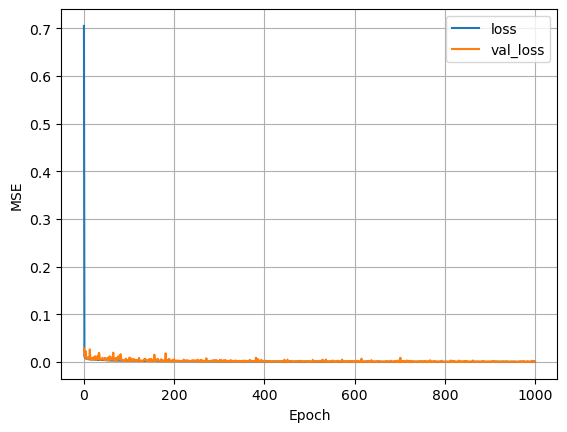

In [9]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [ ]:
model_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/trained_model_mlp_v1_15_obst_1000_epochs.h5'
mlp = keras.models.load_model(model_path)

In [2]:
model_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/trained_model_mlp_v2_15_obst_1000_epochs.h5'
mlp = keras.models.load_model(model_path)

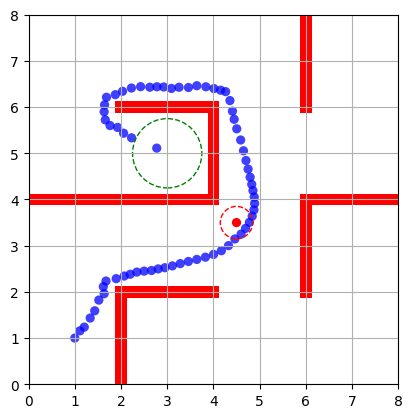

In [3]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
obstaculo = [4.5, 3.5]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

## Modelo con 20 muestras de obstaculo por celda

In [10]:
data = []

with open('trayectorias_20_obst.txt', 'r') as file:
    lines = file.readlines()

# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()

    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-4, 2):
        q_t_q_obst_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1]), float(points[-4]), float(points[-3])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_q_obst_and_q_goal, q_next])

file.close()

In [11]:
# Crea el dataframe
df = pd.DataFrame(data, columns=['(q_t, q_obst, q_goal)', 'q_{t+1}'])
df.head()

,"(q_t, q_obst, q_goal)",q_{t+1}
0,"[1.0, 1.0, 3.9290474606513675, 0.5263086505404...","[1.1164408338385519, 1.162660203367694]"
1,"[1.1164408338385519, 1.162660203367694, 3.9290...","[1.2126045603137046, 1.2526681804882598]"
2,"[1.2126045603137046, 1.2526681804882598, 3.929...","[1.349216862635087, 1.4569734418608196]"
3,"[1.349216862635087, 1.4569734418608196, 3.9290...","[1.4494980303984413, 1.6216811935998123]"
4,"[1.4494980303984413, 1.6216811935998123, 3.929...","[1.5416267325275754, 1.8510645851039822]"


In [12]:
df.shape

(18537, 2)

In [13]:
X = df["(q_t, q_obst, q_goal)"].tolist()
Y = df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [14]:
mlp2 = models.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(2),
])

In [15]:
model_name = 'mlp'
version = 'v2_20_obst'

#models_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/'
models_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/'
save_file_path = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.h5'


# Save the best model only wrt validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp2.compile(loss=keras.losses.MeanSquaredError(),
			optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp2.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 1000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )



Train on 17610 samples, validate on 927 samples
Epoch 1/1000
17610/17610 [==============================] - 1s 37us/step - loss: 1.4125 - val_loss: 0.0148
Epoch 2/1000
17610/17610 [==============================] - 0s 26us/step - loss: 0.0113 - val_loss: 0.0094
Epoch 3/1000
17610/17610 [==============================] - 0s 19us/step - loss: 0.0092 - val_loss: 0.0080
Epoch 4/1000
17610/17610 [==============================] - 0s 17us/step - loss: 0.0085 - val_loss: 0.0078
Epoch 5/1000
17610/17610 [==============================] - 0s 18us/step - loss: 0.0078 - val_loss: 0.0073
Epoch 6/1000
17610/17610 [==============================] - 0s 17us/step - loss: 0.0076 - val_loss: 0.0078
Epoch 7/1000
17610/17610 [==============================] - 0s 17us/step - loss: 0.0070 - val_loss: 0.0074
Epoch 8/1000
17610/17610 [==============================] - 0s 17us/step - loss: 0.0068 - val_loss: 0.0058
Epoch 9/1000
17610/17610 [==============================] - 0s 23us/step - loss: 0.0064 - val_lo

In [16]:
savepath = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.tf'
mlp2.save(filepath=savepath)

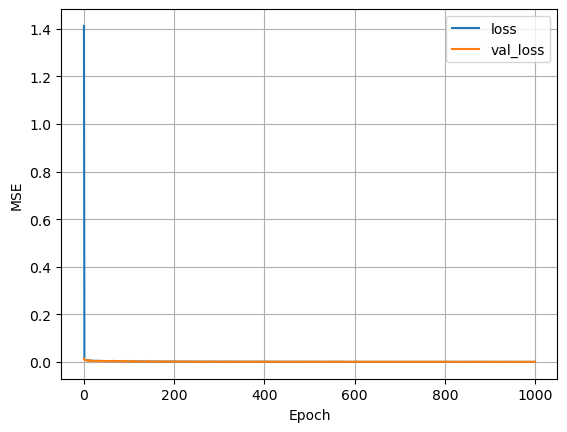

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [ ]:
model_path = '/content/drive/My Drive/Proyecto 2024/Modelos/trained_model_mlp_v1_20_obst_1000_epochs.tf'
mlp2 = keras.models.load_model(model_path)

In [4]:
model_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/trained_model_mlp_v2_20_obst_1000_epochs.h5'
mlp2 = keras.models.load_model(model_path)

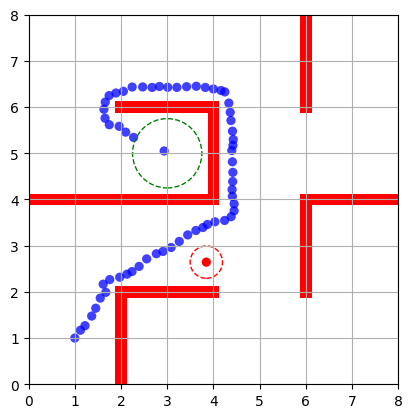

In [5]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [3.8466709809584483, 2.6438260029654916]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp2.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

## Modelo con 25 muestras de obstaculo por celda

In [18]:
data = []

with open('trayectorias_25_obst.txt', 'r') as file:
    lines = file.readlines()

# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()

    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-4, 2):
        q_t_q_obst_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1]), float(points[-4]), float(points[-3])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_q_obst_and_q_goal, q_next])

file.close()

# Crea el dataframe
df = pd.DataFrame(data, columns=['(q_t, q_obst, q_goal)', 'q_{t+1}'])
df.head()

,"(q_t, q_obst, q_goal)",q_{t+1}
0,"[1.0, 1.0, 3.9169264605024883, 1.3453664848083...","[1.1164408338385519, 1.162660203367694]"
1,"[1.1164408338385519, 1.162660203367694, 3.9169...","[1.2126045603137046, 1.2526681804882598]"
2,"[1.2126045603137046, 1.2526681804882598, 3.916...","[1.349216862635087, 1.4569734418608196]"
3,"[1.349216862635087, 1.4569734418608196, 3.9169...","[1.4494980303984413, 1.6216811935998123]"
4,"[1.4494980303984413, 1.6216811935998123, 3.916...","[1.5416267325275754, 1.8510645851039822]"


In [19]:
df.shape

(23288, 2)

In [20]:
X = df["(q_t, q_obst, q_goal)"].tolist()
Y = df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [21]:
mlp3 = models.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(2),
])

In [22]:
model_name = 'mlp'
version = 'v2_25_obst'

#models_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/'
models_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/'
save_file_path = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.h5'


# Save the best model only wrt validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp3.compile(loss=keras.losses.MeanSquaredError(),
			optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp3.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 1000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )



Train on 22123 samples, validate on 1165 samples
Epoch 1/1000
22123/22123 [==============================] - 1s 41us/step - loss: 0.9050 - val_loss: 0.0196
Epoch 2/1000
22123/22123 [==============================] - 0s 20us/step - loss: 0.0103 - val_loss: 0.0105
Epoch 3/1000
22123/22123 [==============================] - 0s 17us/step - loss: 0.0083 - val_loss: 0.0084
Epoch 4/1000
22123/22123 [==============================] - 0s 17us/step - loss: 0.0071 - val_loss: 0.0076
Epoch 5/1000
22123/22123 [==============================] - 0s 17us/step - loss: 0.0065 - val_loss: 0.0058
Epoch 6/1000
22123/22123 [==============================] - 0s 17us/step - loss: 0.0060 - val_loss: 0.0062
Epoch 7/1000
22123/22123 [==============================] - 0s 22us/step - loss: 0.0054 - val_loss: 0.0050
Epoch 8/1000
22123/22123 [==============================] - 0s 17us/step - loss: 0.0054 - val_loss: 0.0046
Epoch 9/1000
22123/22123 [==============================] - 0s 17us/step - loss: 0.0050 - val_l

In [23]:
savepath = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.tf'
mlp3.save(filepath=savepath)

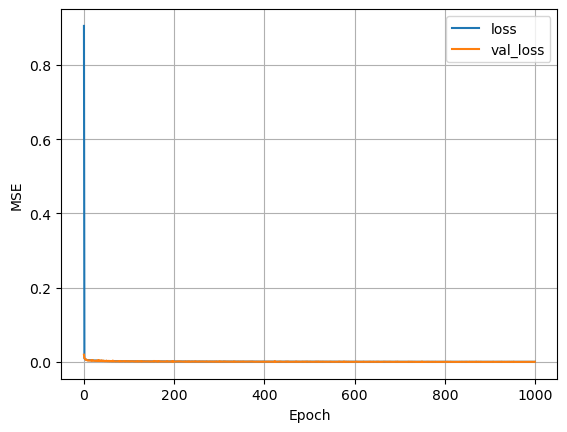

In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [ ]:
model_path = '/content/drive/My Drive/Proyecto 2024/Modelos/trained_model_mlp_v1_25_obst_1000_epochs.h5'
mlp3 = keras.models.load_model(model_path)

In [3]:
model_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/trained_model_mlp_v2_25_obst_1000_epochs.h5'
mlp3 = keras.models.load_model(model_path)

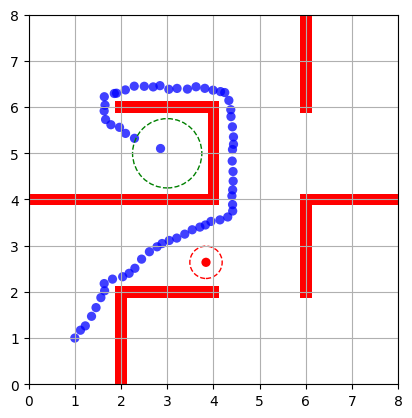

In [8]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [3.84, 2.64]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

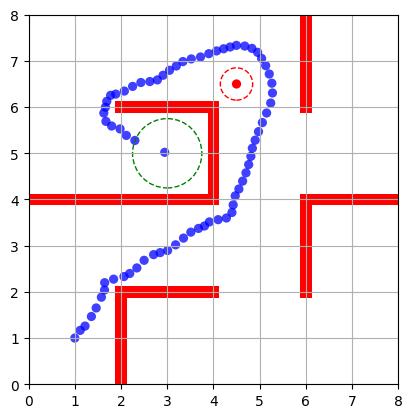

In [9]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [4.5, 6.5]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

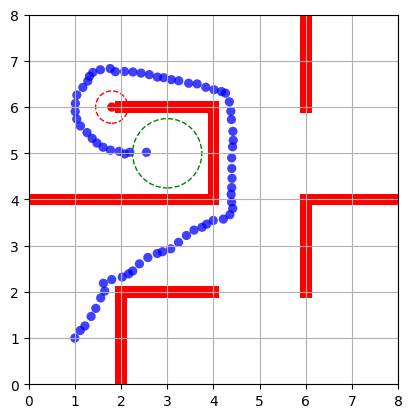

In [11]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [1.8, 6.0]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

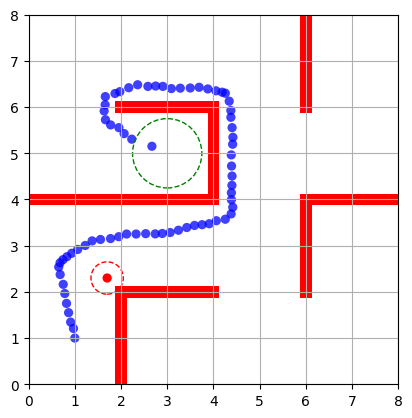

In [12]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [1.7, 2.3]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

## Modelo con 30 muestras de obstaculo por celda

In [2]:
data = []

with open('trayectorias_30_obst.txt', 'r') as file:
    lines = file.readlines()

# Procesa cada línea del archivo
for line in lines:
    # Separa los números en cada línea
    points = line.split()

    # Construimos las tuplas (q_t, q_goal) y q_{t+1}
    for i in range(0, len(points)-4, 2):
        q_t_q_obst_and_q_goal = [float(points[i]), float(points[i+1]), float(points[-2]), float(points[-1]), float(points[-4]), float(points[-3])]
        q_next = [float(points[i+2]), float(points[i+3])]
        data.append([q_t_q_obst_and_q_goal, q_next])

file.close()

# Crea el dataframe
df = pd.DataFrame(data, columns=['(q_t, q_obst, q_goal)', 'q_{t+1}'])
df.head()

,"(q_t, q_obst, q_goal)",q_{t+1}
0,"[1.0, 1.0, 2.593784287206126, 0.98874278423477...","[1.1164408338385519, 1.162660203367694]"
1,"[1.1164408338385519, 1.162660203367694, 2.5937...","[1.2126045603137046, 1.2526681804882598]"
2,"[1.2126045603137046, 1.2526681804882598, 2.593...","[1.349216862635087, 1.4569734418608196]"
3,"[1.349216862635087, 1.4569734418608196, 2.5937...","[1.4494980303984413, 1.6216811935998123]"
4,"[1.4494980303984413, 1.6216811935998123, 2.593...","[1.5416267325275754, 1.8510645851039822]"


In [3]:
df.shape

(28062, 2)

In [4]:
X = df["(q_t, q_obst, q_goal)"].tolist()
Y = df["q_{t+1}"].tolist()

X = np.asarray(X)
Y = np.asarray(Y)

In [5]:
mlp4 = models.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu"),
  layers.Dense(32, activation="relu"),
  layers.Dense(2),
])

In [6]:
model_name = 'mlp'
version = 'v2_30_obst'

#models_path = 'C:/Users/israelb/Desktop/Proyecto 2024/Modelos/'
models_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/'
save_file_path = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.h5'


# Save the best model only wrt validation loss
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=save_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


mlp4.compile(loss=keras.losses.MeanSquaredError(),
			optimizer=keras.optimizers.Adam(learning_rate=0.001))

# Training
history = mlp4.fit(x = X,
				    y = Y,
					batch_size = 128,
					epochs = 1000,
                    validation_split=0.05,
					verbose = 1,
                    callbacks=[model_checkpoint_callback]
                    )



Train on 26658 samples, validate on 1404 samples
Epoch 1/1000
26658/26658 [==============================] - 4s 160us/step - loss: 1.4041 - val_loss: 0.0128
Epoch 2/1000
26658/26658 [==============================] - 1s 47us/step - loss: 0.0096 - val_loss: 0.0091
Epoch 3/1000
26658/26658 [==============================] - 1s 39us/step - loss: 0.0086 - val_loss: 0.0080
Epoch 4/1000
26658/26658 [==============================] - 1s 38us/step - loss: 0.0082 - val_loss: 0.0096
Epoch 5/1000
26658/26658 [==============================] - 1s 40us/step - loss: 0.0078 - val_loss: 0.0112
Epoch 6/1000
26658/26658 [==============================] - 1s 39us/step - loss: 0.0075 - val_loss: 0.0073
Epoch 7/1000
26658/26658 [==============================] - 1s 36us/step - loss: 0.0070 - val_loss: 0.0076
Epoch 8/1000
26658/26658 [==============================] - 1s 36us/step - loss: 0.0066 - val_loss: 0.0060
Epoch 9/1000
26658/26658 [==============================] - 1s 38us/step - loss: 0.0062 - val_

In [7]:
savepath = models_path+'trained_model_'+model_name+'_'+version+'_'+str(1000)+'_epochs.tf'
mlp4.save(filepath=savepath)

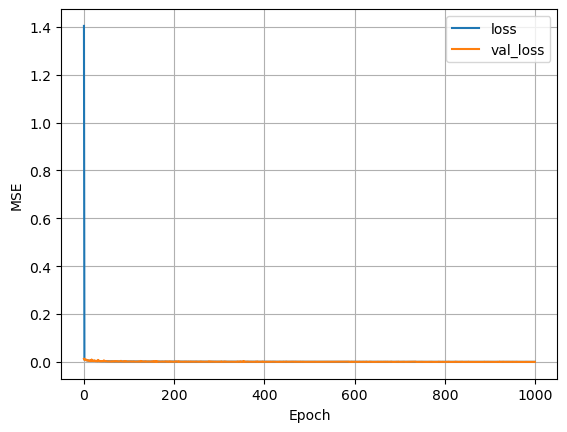

In [8]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)


plot_loss(history)

In [6]:
model_path = 'C:/Users/ramon/Documents/Universidad/Proyecto 2024/Modelos/trained_model_mlp_v2_30_obst_1000_epochs.h5'
mlp4 = keras.models.load_model(model_path)

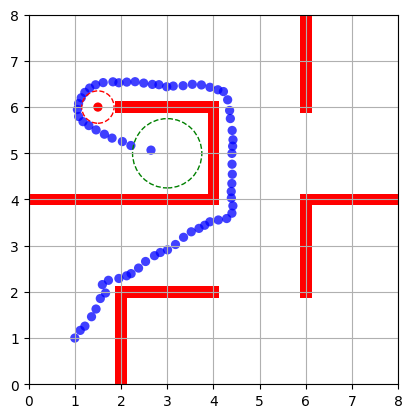

In [8]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = [1.5, 6]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp4.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

# Comparación de modelos

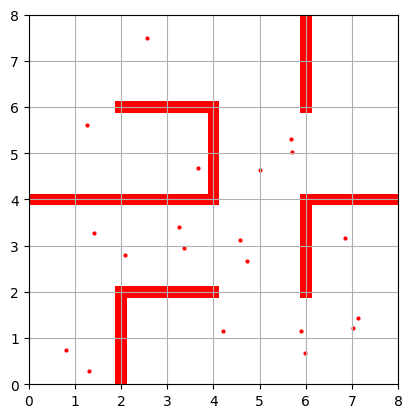

In [27]:
'''Creamos las muestras para validacion'''
v_obstSamples = []

i = 0
while i < 20:
  while True:
    #Generamos punto aleatorio
    v_obst_x = np.random.uniform(liminf_X, limsup_X)
    v_obst_y = np.random.uniform(liminf_Y, limsup_Y)

    #Verificamos que el punto aleatorio este libre de colisiones
    if sampleFree(v_obst_x, v_obst_y, connect_radius):
      v_obstSamples.append(np.array([v_obst_x, v_obst_y]))
      break
  i+=1

fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for o in v_obstSamples:
    plt.scatter(o[0], o[1], color = 'red', s=4.0)

plt.grid()
plt.show()

In [28]:
file = open("v_obstaclePoints.txt", "w")

for o in v_obstSamples:
    file.write(str(o[0]))
    file.write(" ")
    file.write(str(o[1]))
    file.write("\n")

file.close()

In [4]:
v_obstaclePoints = []

with open("v_obstaclePoints.txt", 'r') as file:
    for linea in file:
        x, y = map(float, linea.split())
        v_obstaclePoints.append(np.array([x, y]))

### Modelo con 15 muestras de obstaculo

In [14]:
failed = 0

inicio = [1, 1]
goal = [3, 5]

for i in range(len(v_obstaclePoints)):
    f = False
    obstaculo = v_obstaclePoints[i]

    qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]

    cnt = 0

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
        if sampleFree(qt[0][0], qt[0][1], robot_r) == False or np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(obstaculo)) <= (obst_reach + robot_r):
            failed += 1
            f = True
            break

        qnext = mlp.predict(qt, verbose=0)
        qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
        qt = np.asarray(qt)  

        cnt += 1
    
    if f:
        print(i, ": Failed")
    else:
        print(i, ": Success")

print()
print("Para el modelo con 15 muestras de obstaculo dinamico por celda:")
print("    Pruebas totales: 20")
print("    Predicciones fallidas:", failed)

0 : Success
1 : Success
2 : Failed
3 : Success
4 : Failed
5 : Failed
6 : Success
7 : Failed
8 : Success
9 : Success
10 : Success
11 : Success
12 : Failed
13 : Success
14 : Success
15 : Success
16 : Success
17 : Success
18 : Success
19 : Success

Para el modelo con 15 muestras de obstaculo dinamico por celda:
    Pruebas totales: 20
    Predicciones fallidas: 5


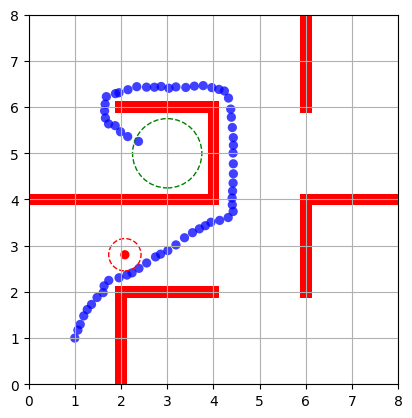

In [15]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = v_obstaclePoints[12]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

### Modelo con 20 muestras de obstaculo

In [16]:
failed = 0

inicio = [1, 1]
goal = [3, 5]

for i in range(len(v_obstaclePoints)):
    f = False
    obstaculo = v_obstaclePoints[i]

    qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]

    cnt = 0

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
        if sampleFree(qt[0][0], qt[0][1], robot_r) == False or np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(obstaculo)) <= (obst_reach + robot_r):
            failed += 1
            f = True
            break

        qnext = mlp2.predict(qt, verbose=0)
        qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
        qt = np.asarray(qt)  

        cnt += 1
    
    if f:
        print(i, ": Failed")
    else:
        print(i, ": Success")

print()
print("Para el modelo con 20 muestras de obstaculo dinamico por celda:")
print("    Pruebas totales: 20")
print("    Predicciones fallidas:", failed)

0 : Success
1 : Success
2 : Failed
3 : Success
4 : Failed
5 : Failed
6 : Success
7 : Failed
8 : Success
9 : Success
10 : Success
11 : Success
12 : Failed
13 : Success
14 : Success
15 : Failed
16 : Success
17 : Success
18 : Success
19 : Success

Para el modelo con 20 muestras de obstaculo dinamico por celda:
    Pruebas totales: 20
    Predicciones fallidas: 6


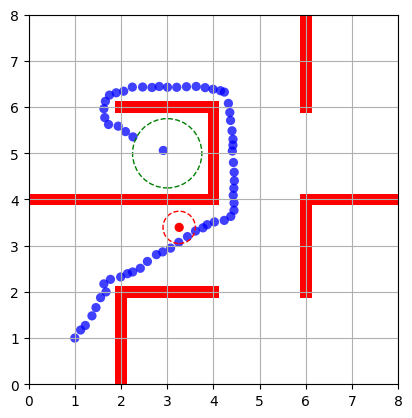

In [17]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = v_obstaclePoints[15]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp2.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

### Modelo con 25 muestras de obstaculo

In [18]:
failed = 0

inicio = [1, 1]
goal = [3, 5]

for i in range(len(v_obstaclePoints)):
    f = False
    obstaculo = v_obstaclePoints[i]

    qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]

    cnt = 0

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
        if sampleFree(qt[0][0], qt[0][1], robot_r) == False or np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(obstaculo)) <= (obst_reach + robot_r):
            failed += 1
            f = True
            break

        qnext = mlp3.predict(qt, verbose=0)
        qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
        qt = np.asarray(qt)

        cnt += 1
    
    if f:
        print(i, ": Failed")
    else:
        print(i, ": Success")

print()
print("Para el modelo con 25 muestras de obstaculo dinamico por celda:")
print("    Pruebas totales: 20")
print("    Predicciones fallidas:", failed)

0 : Success
1 : Success
2 : Success
3 : Success
4 : Failed
5 : Success
6 : Success
7 : Failed
8 : Success
9 : Success
10 : Success
11 : Success
12 : Success
13 : Success
14 : Success
15 : Success
16 : Success
17 : Success
18 : Success
19 : Success

Para el modelo con 25 muestras de obstaculo dinamico por celda:
    Pruebas totales: 20
    Predicciones fallidas: 2


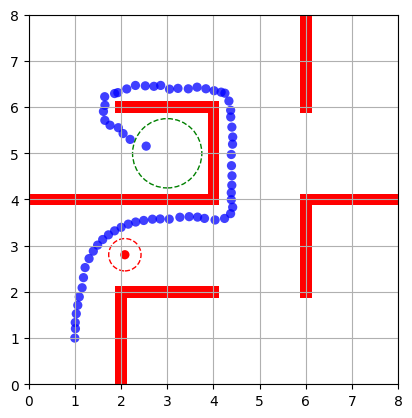

In [9]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = v_obstaclePoints[12]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp3.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()

## Modelo con 30 muestras de obstáculo

In [10]:
failed = 0

inicio = [1, 1]
goal = [3, 5]

for i in range(len(v_obstaclePoints)):
    f = False
    obstaculo = v_obstaclePoints[i]

    qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]

    cnt = 0

    while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
        if sampleFree(qt[0][0], qt[0][1], robot_r) == False or np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(obstaculo)) <= (obst_reach + robot_r):
            failed += 1
            f = True
            break

        qnext = mlp4.predict(qt, verbose=0)
        qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
        qt = np.asarray(qt)  

        cnt += 1
    
    if f:
        print(i, ": Failed")
    else:
        print(i, ": Success")

print()
print("Para el modelo con 30 muestras de obstaculo dinamico por celda:")
print("    Pruebas totales: 20")
print("    Predicciones fallidas:", failed)

0 : Success
1 : Success
2 : Failed
3 : Success
4 : Failed
5 : Success
6 : Success
7 : Failed
8 : Success
9 : Success
10 : Success
11 : Success
12 : Success
13 : Failed
14 : Success
15 : Success
16 : Success
17 : Success
18 : Success
19 : Success

Para el modelo con 30 muestras de obstaculo dinamico por celda:
    Pruebas totales: 20
    Predicciones fallidas: 4


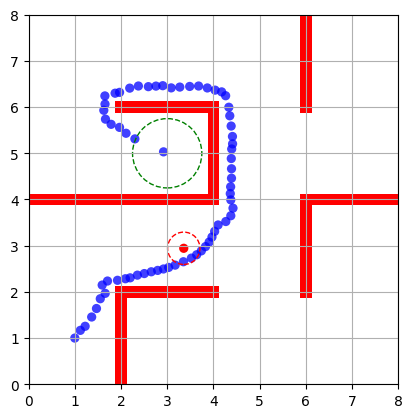

In [12]:
verticesPath = []

inicio = [1, 1]
goal = [3, 5]
#obstaculo = [4.5, 3.5]
obstaculo = v_obstaclePoints[4]

qt = [[inicio[0], inicio[1], obstaculo[0], obstaculo[1], goal[0], goal[1]]]
verticesPath.append([qt[0][0],qt[0][1]])

cnt = 0

while np.linalg.norm(np.array([qt[0][0],qt[0][1]]) - np.array(goal)) >= 0.75 and cnt <= 500:
    qnext = mlp4.predict(qt, verbose=0)
    qt = [[qnext[0][0], qnext[0][1],  obstaculo[0], obstaculo[1], goal[0], goal[1]]]
    qt = np.asarray(qt)
    verticesPath.append([qnext[0][0],qnext[0][1]])
    cnt += 1


fig, ax = plt.subplots()
ax.set_xlim(liminf_X, limsup_X)
ax.set_ylim(liminf_Y, limsup_Y)
ax.set_aspect('equal')

for i in range(len(obstacles)):
  ax.add_patch(Rectangle(obstacles[i].pos, obstacles[i].width, obstacles[i].height,
             facecolor = 'red',
             fill=True))

for v in verticesPath:
    ax.add_patch(Circle((v[0], v[1]), robot_r, facecolor='blue', alpha = 0.75))

ax.add_patch(Circle((goal[0], goal[1]), 0.75, edgecolor='green', ls = '--', fill = False))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obstacle_r, facecolor='red'))
ax.add_patch(Circle((obstaculo[0], obstaculo[1]), obst_reach, edgecolor='red', ls = '--', fill = False))

plt.grid()
plt.show()